# Phase 2: Model Building and Evaluation
This notebook covers the modeling phase of the project "Cracking the Market Code with AI-Driven Stock Price Prediction".
We will use LSTM and Linear Regression to forecast stock prices based on historical time series data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
data = yf.download("AAPL", start="2020-01-01", end="2023-12-31")
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['Lag1'] = data['Close'].shift(1)
data.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'MA10', 'MA50', 'Lag1']])

In [4]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, 60)
X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

In [5]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60, X.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

c:\Users\hari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0456
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0045
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0030
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0027
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0023
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0018
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0018
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0016
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0016


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


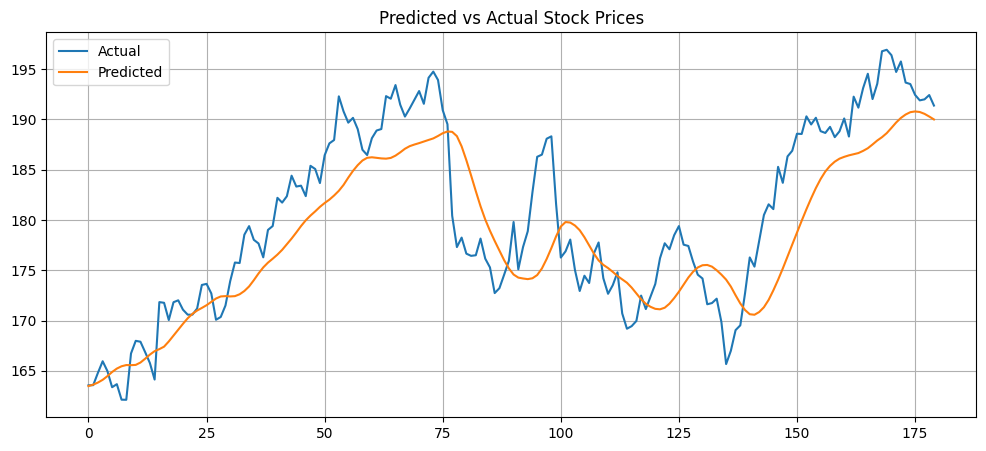

MAE: 4.212413020163785
RMSE: 5.057059560630657
R² Score: 0.6939853433821068


In [6]:
predictions = model.predict(X_test)

pred_rescaled = scaler.inverse_transform(np.hstack((predictions, np.zeros((len(predictions), 3)))))[:, 0]
actual_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 3)))))[:, 0]

plt.figure(figsize=(12, 5))
plt.plot(actual_rescaled, label='Actual')
plt.plot(pred_rescaled, label='Predicted')
plt.title("Predicted vs Actual Stock Prices")
plt.legend()
plt.grid()
plt.show()

print("MAE:", mean_absolute_error(actual_rescaled, pred_rescaled))
print("RMSE:", mean_squared_error(actual_rescaled, pred_rescaled) ** 0.5)
print("R² Score:", r2_score(actual_rescaled, pred_rescaled))

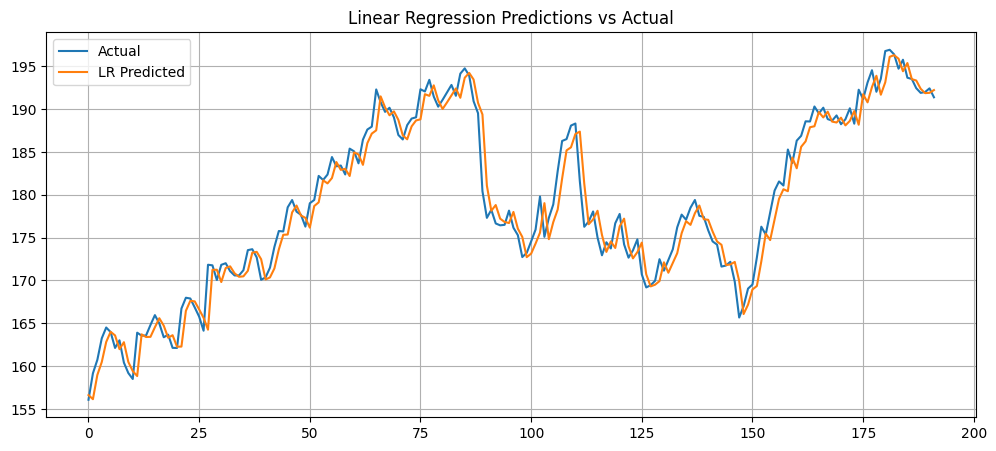

In [7]:
df = data.copy()
df.dropna(inplace=True)
X_lr = df[['MA10', 'MA50', 'Lag1']]
y_lr = df['Close']
split_index = int(0.8 * len(X_lr))

lr_model = LinearRegression()
lr_model.fit(X_lr[:split_index], y_lr[:split_index])
lr_preds = lr_model.predict(X_lr[split_index:])

plt.figure(figsize=(12, 5))
plt.plot(y_lr[split_index:].values, label='Actual')
plt.plot(lr_preds, label='LR Predicted')
plt.title("Linear Regression Predictions vs Actual")
plt.legend()
plt.grid()
plt.show()